## Run First


In [ ]:
import numpy as np
from numpy import linalg as LA
from time import process_time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
import math
from scipy import sparse
from scipy.sparse import random
from scipy import stats
from numpy.random import default_rng
from sklearn.preprocessing import normalize

In [ ]:
def residual_error(A, x, y):
  r_error = (np.linalg.norm(A@x-y))**2
  return r_error

In [ ]:
def approximation_error(xk, xnew):
  a_error = (np.linalg.norm(xk-xnew))**2
  return a_error

In [ ]:
def rse(xk, xs):
  rse = ((np.linalg.norm(xk-xs))**2) / (np.linalg.norm(xs))**2
  return rse

## Greedy Kaczmarz / Motzkin's Method

In [ ]:
def MM(A, x, y, TOL = 0.01):
  k=1
  m, n = A.shape
  x_old = np.zeros(n)
  x_lst = [x_old]
  r_error = []
  ap_error = []
  ar = approximation_error(x_old, x)
  ap_error.append(ar)
  while True:
    r = []
    for i in range(m):
      resid = (np.transpose(A[i,:])@x_old - y[i])**2
      r.append(resid)
    i = np.argmax(r)
    ai = A[i,:]
    x_new = x_old - ((np.transpose(ai)@x_old - y[i]) * ai)
    x_lst.append(x_new)
    x_old = x_new
    ar = approximation_error(x_old, x)
    ap_error.append(ar)
    er = residual_error(A, x_old, y)
    r_error.append(er)
    k+=1
    if ar < TOL:
      break
  return k, r_error, ap_error

## Greedy Oblique Kaczmarz

In [ ]:
def GOK(A, x, y, TOL = 0.01):
  k=1
  m, n = A.shape
  x_old = np.zeros(n)
  x_lst = [x_old]
  r_error = []
  ap_error = []
  ar = approximation_error(x_old, x)
  ap_error.append(ar)
  row_lst = []
  [ik, i_k1] = np.random.choice(range(m), 2)
  row_lst.extend([ik, i_k1])
  a1 = A[ik,:]
  x1 = x_old + ((y[ik] - a1@x_old) / np.linalg.norm(a1)**2) * np.transpose(a1)
  x_lst.append(x1)
  a2 = A[i_k1,:]
  x2 = x1 + ((y[i_k1] - a2@x1) / (np.linalg.norm(a2)**2 - (((a1@a2)**2)/np.linalg.norm(a1)**2))) * ((a2 - (a1@a2)/np.linalg.norm(a1)**2) * a1)
  x_lst.append(x2)
  x_old = x2

  while True:
    t_lst = []
    ik = row_lst[-1]
    for i in range(m):
      if i != ik:
        r = y[i] - A[i,:]@x_lst[-1]
        w = A[i,:] - ( ( A[ik,:]@A[i,:] / np.linalg.norm(A[ik,:])**2 ) * A[ik,:] )
        t = abs(r) / np.linalg.norm(w)**2
        t_lst.append([i,t])
    # Choose the row with max t
    [i_k1,t_lst] = max(t_lst,key = lambda x : x[1])
    row_lst.append(i_k1)
    #print(i_k1)
    # Do RKO with the i
    ai = A[ik,:] # a_k-1
    ai_k = A[i_k1,:] # a_k
    D_ik = ai@ai_k
    r = y[i_k1] - ai_k@x_old
    w = ai_k - ((D_ik / np.linalg.norm(ai)**2) * ai)
    h_ik = np.linalg.norm(w)**2
    alpha = r / h_ik
    xk = x_old + alpha*w
    x_old = xk
    x_lst.append(x_old)
    ar = approximation_error(x_old, x)
    ap_error.append(ar)
    er = residual_error(A, x_old, y)
    r_error.append(er)
    k+=1

    if ar < TOL:
      break
  return k, r_error, ap_error

## Maximal Weighted Residual Kaczmarz Method with Oblique Projection (MWRKO)

In [ ]:
def MWRKO(A, x, y, TOL = 0.01):
  k=1
  m, n = A.shape
  x_old = np.zeros(n)
  x_lst = [x_old]
  r_error = []
  ap_error = []
  t_lst = []
  ar = approximation_error(x_old, x)
  ap_error.append(ar)
  row_lst = []
  for i in range(m):
      r = abs(y[i] - A[i,:]@x_lst[-1])
      w = np.linalg.norm(A[i,:])
      t = r / w
      t_lst.append([i,t])
  [ik, t_lst] = max(t_lst,key = lambda x : x[1])
  row_lst.append(ik)
  a1 = A[ik,:]
  x1 = x_old + ((y[ik] - a1@x_old) / np.linalg.norm(a1)**2) * np.transpose(a1)
  x_lst.append(x1)
  x_old = x1

  while True:
    t_lst = []
    ik = row_lst[-1]
    for i in range(m):
      if i != ik:
        r = abs(y[i] - A[i,:]@x_lst[-1])
        w = np.linalg.norm(A[i,:])
        t = r / w
        t_lst.append([i,t])
    # Choose the row with max t
    [i_k1,t_lst] = max(t_lst,key = lambda x : x[1])
    row_lst.append(i_k1)
    #print(i_k1)
    # Do RKO with the i
    ai = A[ik,:] # a_k-1
    ai_k = A[i_k1,:] # a_k
    D_ik = ai@ai_k
    r = y[i_k1] - ai_k@x_old
    w = ai_k - ((D_ik / np.linalg.norm(ai)**2) * ai)
    h_ik = np.linalg.norm(w)**2
    alpha = r / h_ik
    xk = x_old + alpha*w
    x_old = xk
    x_lst.append(x_old)
    ar = approximation_error(x_old, x)
    ap_error.append(ar)
    er = residual_error(A, x_old, y)
    r_error.append(er)
    k+=1

    if ar < TOL:
      break
  return k, r_error, ap_error

## Experiments

### Uniform

In [ ]:
#uniform
A = np.random.rand(5000,500)
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x

In [ ]:
mm_uniform = MM(A,x,y)

KeyboardInterrupt: ignored

In [ ]:
gok_uniform = GOK(A,x,y)

In [ ]:
mwrko_uniform = MWRKO(A,x,y)

In [ ]:
plt.figure(figsize=(10,7))

plt.semilogy(np.arange(mm_uniform[0]), mm_uniform[2], label = 'MM')
plt.semilogy(np.arange(gok_uniform[0]), gok_uniform[2], label = 'GOK')
plt.semilogy(np.arange(mwrko_uniform[0]), mwrko_uniform[2], label = 'MWRKO')

plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Relative Solution Error (Uniform)')
plt.legend()

### Gaussian

In [ ]:
#gaussian
A = np.random.randn(5000,500)
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x

In [ ]:
mm_gaussian = MM(A,x,y)

In [ ]:
gok_gaussian = GOK(A,x,y)

In [ ]:
mwrko_gaussian = MWRKO(A,x,y)

In [ ]:
plt.figure(figsize=(10,7))

plt.semilogy(np.arange(mm_gaussian[0]), mm_gaussian[2], label = 'MM')
plt.semilogy(np.arange(gok_gaussian[0]), gok_gaussian[2], label = 'GOK')
plt.semilogy(np.arange(mwrko_gaussian[0]), mwrko_gaussian[2], label = 'MWRKO')

plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Relative Solution Error (Gaussian)')
plt.legend()

### Combination (50/50)

In [ ]:
#combination
A1 = np.random.rand(2500,500)
A2 = np.random.randn(2500,500)
A = np.concatenate((A1, A2))
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x

In [ ]:
mm_comb = MM(A,x,y)

In [ ]:
gok_comb = GOK(A,x,y)

In [ ]:
mwrko_comb = MWRKO(A,x,y)

In [ ]:
plt.figure(figsize=(10,7))

plt.semilogy(np.arange(mm_comb[0]), mm_comb[2], label = 'MM')
plt.semilogy(np.arange(gok_comb[0]), gok_comb[2], label = 'GOK')
plt.semilogy(np.arange(mwrko_comb[0]), mwrko_comb[2], label = 'MWRKO')

plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Combination)')
plt.legend()

## Average Combination

In [ ]:
#combination
A1 = np.random.rand(2500,500)
A2 = np.random.randn(2500,500)
A = np.concatenate((A1, A2))
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x

In [ ]:
#rkn_iter1 = []
mm_iter1 = []
#rkon_iter1 = []
gok_iter1 = []
#adrkon1_iter1 = []
mwrko_iter1 = []
#adrkon3_iter1 = []

In [ ]:
for i in range(10):
  mm_comb = MM(A,x,y)
  gok_comb = GOK(A,x,y)
  mwrko_comb = MWRKO(A,x,y)

  mm_iter1.append(mm_comb[0])
  gok_iter1.append(gok_comb[0])
  mwrko_iter1.append(mwrko_comb[0])

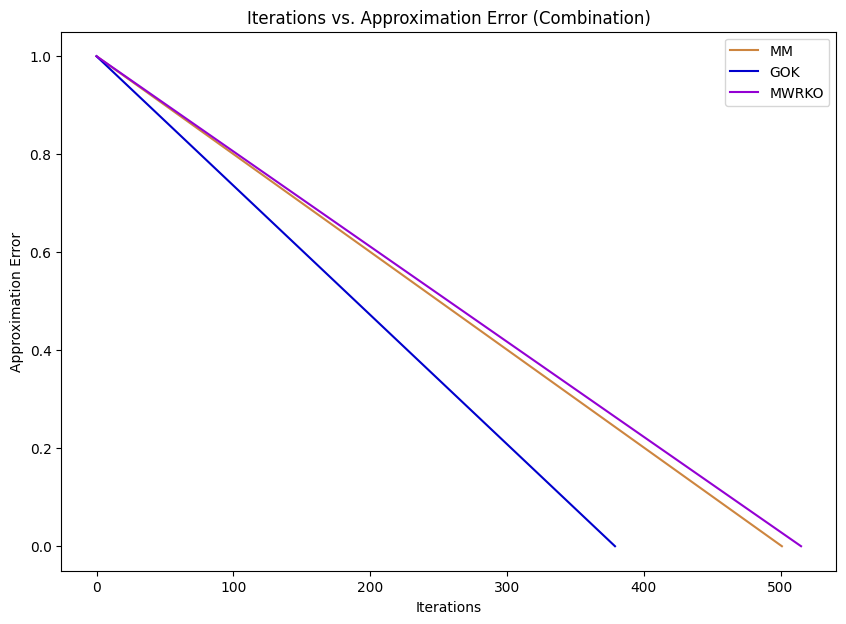

In [ ]:
plt.figure(figsize=(10, 7))
# Approximation Error vs Iterations
plt.plot(list(range(np.mean(mm_iter1).astype(int))), np.linspace(1,0,np.mean(mm_iter1).astype(int)), color = 'peru', label = "MM")
plt.plot(list(range(np.mean(gok_iter1).astype(int))), np.linspace(1,0,np.mean(gok_iter1).astype(int)), color = 'mediumblue', label = "GOK")
plt.plot(list(range(np.mean(mwrko_iter1).astype(int))), np.linspace(1,0,np.mean(mwrko_iter1).astype(int)), color = 'darkviolet', label = "MWRKO")
#plt.set(xlabel='Iterations', ylabel='Approximation Error', title='Approximation Error vs Iterations')

plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Combination)')
plt.legend()

## Average Uniform

In [ ]:
#combination
A = np.random.rand(5000,500)
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x

In [ ]:
#rkn_iter1 = []
mm_iter1 = []
#rkon_iter1 = []
gok_iter1 = []
#adrkon1_iter1 = []
mwrko_iter1 = []
#adrkon3_iter1 = []

In [ ]:
for i in range(10):
  mm_comb = MM(A,x,y)
  gok_comb = GOK(A,x,y)
  mwrko_comb = MWRKO(A,x,y)

  mm_iter1.append(mm_comb[0])
  gok_iter1.append(gok_comb[0])
  mwrko_iter1.append(mwrko_comb[0])

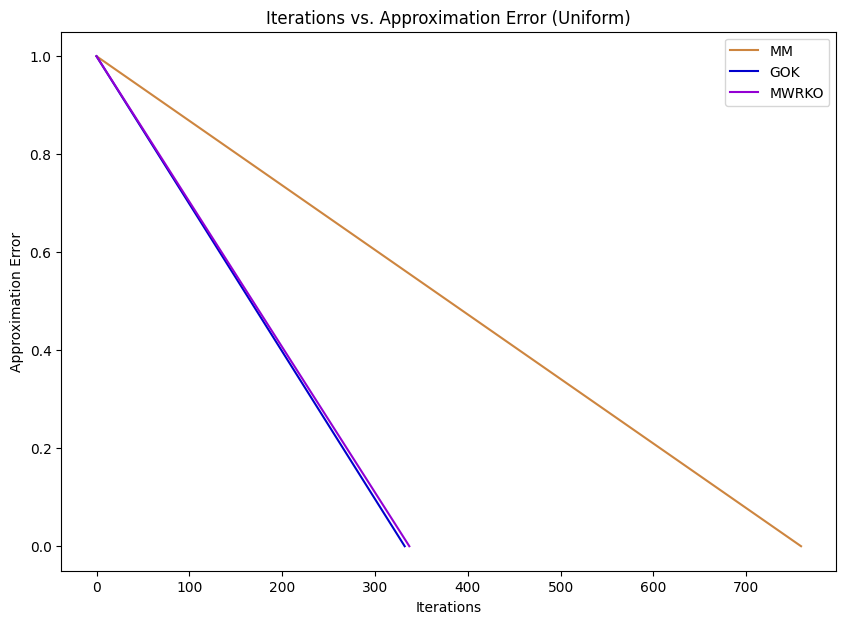

In [ ]:
plt.figure(figsize=(10, 7))
# Approximation Error vs Iterations
plt.plot(list(range(np.mean(mm_iter1).astype(int))), np.linspace(1,0,np.mean(mm_iter1).astype(int)), color = 'peru', label = "MM")
plt.plot(list(range(np.mean(gok_iter1).astype(int))), np.linspace(1,0,np.mean(gok_iter1).astype(int)), color = 'mediumblue', label = "GOK")
plt.plot(list(range(np.mean(mwrko_iter1).astype(int))), np.linspace(1,0,np.mean(mwrko_iter1).astype(int)), color = 'darkviolet', label = "MWRKO")
#plt.set(xlabel='Iterations', ylabel='Approximation Error', title='Approximation Error vs Iterations')

plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Uniform)')
plt.legend()